# Maximum Likelihood RUN 1

### The raw PyBDSF catalogue, optical, NIR catalogues and, the MASTER LIST are used

---

In [5]:
# Load in all the required functions

from socket import gethostname

if gethostname() == 'colonsay':
    PATH_START = '/disk1/rohitk/ELN1_project/'

elif gethostname() == 'rohitk-elitebook':
    PATH_START = '/home/rohitk/Documents/PhD/Year1/ELN1_project/'

# Path start for Max_L analysis
# PATH_START = PATH_START + "OCT17_ELAIS_im/maxl_test/"
    
#################################################
# Add the path of useful functions at the start

import sys

# Import some important functions
#sys.path.append(PATH_START+'basic_functions')

import importlib

# Import coordinate converstion functions
from useful_functions import field_filter, get_overlap_sources, latest_dir, logspace_bins, return_hist_par
#from overlapping_area import (isinpan, isinukidss, isinSWIRE, isinSERVS)
from plot_func import rc_def, make_fig
from moc_util import coords_to_hpidx, inMoc
rc_def()
##################################################

import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table

import time

from astropy.coordinates import search_around_sky
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky


# Multiprocessin method of doing the ML analysis
import multiprocessing as mp
from functools import partial

import pickle

ts = time.time()
# %pylab inline
import matplotlib as mpl
mpl.rcParams["font.size"] = 18
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 18
mpl.rcParams["axes.labelsize"] = 18

import os
from time import strftime
import glob

# For MOC files
import pymoc.io.fits
import healpy as hp
import pymoc.util.catalog

ImportError: cannot import name 'coords_to_hpidx'

In [7]:
# Import ML functions from mlrun1
import mlrun1_bootes
importlib.reload(mlrun1_bootes)


from mlrun1_bootes import (varstat, survey_area, get_sigma_all_old, get_fr_old, get_bin_list, get_n_m, get_q_m, 
                    generate_rand_pos_servs, get_Q0, compute_Fr, get_nm_interp,
                    get_qm_interp, get_lr)

from mlrun1_bootes import (generate_rand_pos_bootes, get_n_m_kde, get_q_m_kde, estimate_q_m_kde, get_sigma_all, gen_binc_binl)

# from mlrun1 import survey_area

NameError: name 'PATH_START' is not defined

## Contents

- [Function Definitions](#func-def)
    - [Miscellaneous](#misc-func)
- [Load Catalogues](#load-catalogues)
- [Filter LOFAR Catalogue](#filter-lofar)
- [PanSTARRS i band](#pani-analysis)
    - [Filter PanSTARRS i-band](#filter-pani)
    - [Compute Q$_0$](#comp-q0_i)
        - [Compute F(r)](#comp-fR_i)
    - [Compute n(m)](#comp-nm_i)
    - [Compute q(m)](#comp-qm_i)
- [Compile i-band LR](#comp-lr_i)
- [PanSTARRS g band](#pang-analysis)
    - [Filter PanSTARRS g-band](#filter-pang)
    - [Compute Q$_0$](#comp-q0_g)
        - [Compute F(r)](#comp-fR_g)
    - [Compute n(m)](#comp-nm_g)
    - [Compute q(m)](#comp-qm_g)
- [Compile g-band LR](#comp-lr_g)
- [UKIDSS K band](#K-analysis)
    - [Filter UKIDSS K-band](#filter-k)
    - [Compute Q$_0$](#comp-q0_k)
        - [Compute F(r)](#comp-fR_k)
    - [Compute n(m)](#comp-nm_k)
    - [Compute q(m)](#comp-qm_k)
- [Compile K-band LR](#comp-lr_k)
- [SERVS/SWIRE band](#s-analysis)
    - [Filter s-band](#filter-s)
    - [Compute Q$_0$](#comp-q0_s)
        - [Compute F(r)](#comp-fR_s)
    - [Compute n(m)](#comp-nm_s)
    - [Compute q(m)](#comp-qm_s)
- [Compile s-band LR](#comp-lr_s)

- [ML Colour Analysis](#ml_colour)
- [Colour Bin Definition](#col_cat_def)
- [K/Ks only categories](#gik_only_col_cat)

### Survey areas <a class="anchor" id="survey-area"></a>

In [44]:
# Survey area definitions - used for generated random catalogue and select the relevant PanSTARRS sources

# Rectangular region for n(m) calculation
p_ra_down = 217.
p_dec_down = 34.
p_ra_up = 220.
p_dec_up = 35.

"""
p_ra_down = 216.2
p_ra_up = 218.8
p_dec_down = 33.0
p_dec_up = 35.6
""";

# UKIDSS survey area

# Get the area of the rectangle used for n(m)
pan_area = survey_area(p_ra_up, p_dec_up, p_ra_down, p_dec_down)
print(pan_area / 3600**2)

2.472347185586362


## Load Catalogues <a class="anchor" id="load-catalogues"></a>

In [45]:
# Definition of the paths
PATH_PYBDSF_RAW = "/disk3/rohitk/Bootes/radio/image_full_ampphase_di_m.NS_shift.blanked.scaled.cat.fits"
PATH_MASTER_LIST = "/disk3/rohitk/Bootes/Bootes_optical/MASTER_catalogue/Bootes_MASTER_opt_spitzer_merged.fits"

In [46]:
# Get the type of catalogue (srl) or (gaul)
if PATH_PYBDSF_RAW.split("/")[-1][-8:-5] == "cat":
    cat_type = "_srl"
    id_type = "Source_id"  # Column name to choose - NOT USED
elif PATH_PYBDSF_RAW.split("/")[-1][-9:-5] == "gaul":
    cat_type = "_gaul"
    id_type = "Gaus_id"
    
print(cat_type)

_srl


In [47]:
# Read in Master List - This contains all of the magnitudes for the 20 filters
master = Table.read(PATH_MASTER_LIST)

# Read in Final Catalogue - LOFAR DATA
deepfull = Table.read(PATH_PYBDSF_RAW)


## Filter LOFAR Catalogue and MASTER catalogue <a class="anchor" id="filter-lofar"></a>

In [48]:
# Read in the MOC file
PATH_MOC = "/disk3/rohitk/Bootes/Bootes_optical/moc_files/Bootes_I-band_MOC.fits"

# Generate a MOC class instance first
cata_moc = pymoc.MOC()
pymoc.io.fits.read_moc_fits(cata_moc, PATH_MOC)

moc_area = cata_moc.area_sq_deg
print("Area of MOC: {0} sq. deg.".format(moc_area))

Area of MOC: 9.643885598599503 sq. deg.


In [49]:
NEW_MOC = "/disk3/rohitk/Bootes/Bootes_optical/moc_files/stitch_moc/Bootes_i_MOC.fits"

moc_i = pymoc.MOC()
pymoc.io.fits.read_moc_fits(moc_i, NEW_MOC)

imoc_area = moc_i.area_sq_deg
print("Area of MOC: {0} sq. deg.".format(imoc_area))

Area of MOC: 9.467311334732925 sq. deg.


In [51]:
radio_inmoc = inMoc(deepfull["RA"], deepfull["DEC"], cata_moc)
print("Number of radio sources in OLD MOC: {0}".format(np.sum(radio_inmoc)))

radio_innewmoc = inMoc(deepfull["RA"], deepfull["DEC"], moc_i)
print("Number of radio sources in NEW MOC: {0}".format(np.sum(radio_innewmoc)))

Number of radio sources in OLD MOC: 20586
Number of radio sources in NEW MOC: 20355


In [55]:
# Sources not in NEW moc but in OLD moc
not_in_new = radio_inmoc & ~radio_innewmoc
print(np.sum(not_in_new))

deepfull[not_in_new].write("lofar_in_old_moc_not_in_new.fits", overwrite=True)
deepfull["RA", "DEC"][not_in_new].write("lofar_pos_in_old_moc_not_in_new.txt", format='ascii.commented_header', overwrite=True)

231


In [9]:
# Filter the LOFAR catalogue to the overlapping area and S sources and a Maj size cut
"""
Coordinates for the Radio FIR overlap area
ov_ra_d = 216.2
ov_ra_up = 218.8
ov_dec_d = 33.0
ov_dec_up = 35.6
"""

maj_cut = 10.  # Major axis size cut (in arcsec) for radio catalogue

# Radio sources in MOC
radio_inmoc = inMoc(deepfull["RA"], deepfull["DEC"], cata_moc)
print("Number of radio sources in MOC: {0}".format(np.sum(radio_inmoc)))

workflow_iter = False


if workflow_iter:
    workflow_latest_dir = latest_dir("/disk3/rohitk/Bootes/bootes_workflow/workflow_iter_*")
    indx_forlr = pickle.load(open(workflow_latest_dir + "/sources_to_send_to_lr.pckl", "rb"))
    
    print("***** USING LOFAR SOURCES FROM WORKFLOW OUTPUT ****")
    
else:
    indx_forlr = ((deepfull['S_Code'] == 'S') &
                  (deepfull["Maj"]*3600. <= maj_cut) &
                  (radio_inmoc))

# Now index and get the entire catalogue
final = deepfull[indx_forlr]
print("Number of radio sources in MOC, S and Maj < {0}'': {1}".format(maj_cut, np.sum(indx_forlr)))

# Radio sources in the rectangular area for n(m) calculation
radio_rect = field_filter(p_ra_up, p_dec_up, p_ra_down, p_dec_down, deepfull["RA"], deepfull["DEC"])
print("Radio sources within rectangle: {0}".format(np.sum(radio_rect)))

Number of radio sources in MOC: 20586
Number of radio sources in MOC, S and Maj < 10.0'': 15291
Radio sources within rectangle: 6584


## I-band ML matching <a class="anchor" id="pani_analysis"></a>

### n(m) PanSTARRS i-band <a class="anchor" id="comp-nm_i"></a>

$\textbf{Definition:}$ n(m) is the number of sources in the optical/NIR catalogue below a magnitude, m within an area of 1arcsec (i.e. divide by the area of the survey)

In [33]:
filt = "I"
mag_col = filt + "_mag_2"
flux_col = filt + "_flux_2"
fluxerr_col = filt + "_fluxerr_2"

null_mag = -99

snr_th = 3.

snr_band = (master[flux_col] / master[fluxerr_col] >= snr_th)

# Set the FLAG_DEEP of Spitzer only sources to -99s
master["FLAG_DEEP"].fill_value = -99
master["FLAG_DEEP"] = master["FLAG_DEEP"].filled(-99)

flag_cond = (master["FLAG_DEEP"] == 1) | (master["FLAG_DEEP"] == -99)

Optical sources used for n(m) calculation: 315532
Properties of n(m) in i-band: 
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
0.003984   0.000532   0.004548   559        1.5331513400367e-67 0.009848   0         


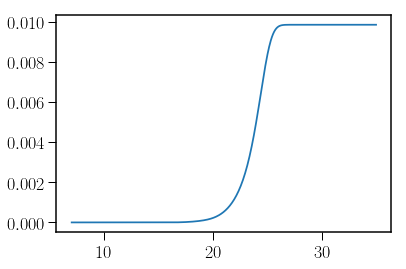

In [34]:
# Get sources for the n(m) calculation

filt = "I"
mag_col = filt + "_mag_2"
flux_col = filt + "_flux_2"
fluxerr_col = filt + "_fluxerr_2"

# Find all the optical catalogue sources within the rectangle and those with non-99 magnitudes and SNR >= threshold
master_rect_ind = ((field_filter(p_ra_up, p_dec_up, p_ra_down, p_dec_down, master["ALPHA_J2000"], master["DELTA_J2000"])) & (master[mag_col] != null_mag) &
                  ~np.isnan(master[mag_col]) & snr_band & flag_cond)

print("Optical sources used for n(m) calculation: {0}".format(np.sum(master_rect_ind)))

# Get the bin_list for computing n(m) for i band
# _, nm_be_i, nm_bc_i = return_hist_par(0.05, master[mag_col][master_rect_ind])

nm_be_i, nm_bc_i = gen_binc_binl(7., 35., 0.05)

# Get n(m) for the i band
nm_i_old = get_n_m(master[mag_col][master_rect_ind], nm_be_i, pan_area)

nm_i = get_n_m_kde(master[mag_col][master_rect_ind], nm_bc_i, area=pan_area, bandwidth=0.5)

# Print properties of the n(m) distribution
print("Properties of n(m) in i-band: ")
varstat(np.cumsum(nm_i))

# Compute sigma for each source
# print("Diff in PanSTARRS area: " + str(46390728.8503 - pan_area)+" arcsec**2")

fig = plt.figure()

plt.plot(nm_bc_i, np.cumsum(nm_i))

In [41]:
# Write the n(m) distribution to pckl file to compare with the other fields
pickle.dump([nm_bc_i, nm_i, nm_i_old], open("Bootes_nm_i_2asec.pckl", "wb"))

## q(m) PanSTARRS i-band <a class="anchor" id="comp-qm_i"></a>

$\textbf{Definition:}$ q(m) is the apriori probability that the radio source has a counterpart brighter than magnitude m.
* Depends on real(m) and Q$_0$

In [36]:
lofar_co = SkyCoord(final['RA'], final['DEC'], unit=(u.deg,u.deg),
                    frame='icrs')
lofar_rect = SkyCoord(deepfull['RA'][radio_rect], deepfull['DEC'][radio_rect], unit=(u.deg,u.deg),
                    frame='icrs')

# Define i-only sources as sources with a SNR > 3 (or 5) in the i-band
i_only_bool = (flag_cond) & (master[mag_col] != null_mag) & (~np.isnan(master[mag_col]) & snr_band)

# i_only_bool = (master[mag_col] != 99) & (~np.isnan(master[mag_col]))
# print(np.sum(i_only_bool))

i_coords = SkyCoord(master['ALPHA_J2000'][i_only_bool], 
                       master['DELTA_J2000'][i_only_bool],
                       unit=(u.deg,u.deg),frame='icrs')

print("No. of LOFAR and I-band sources used in analysis from now on: ", len(lofar_co))
print("No. of i-band sources used for LR cross-match: {0}".format(np.sum(i_only_bool)))

No. of LOFAR and I-band sources used in analysis from now on:  15291
No. of i-band sources used for LR cross-match: 1468723


Unique opt_ind:  23882
Unique LOFAR ind:  13230


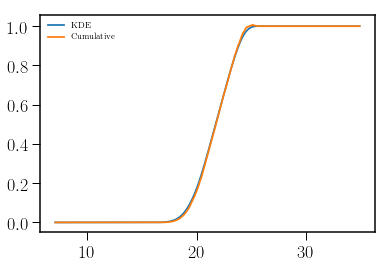

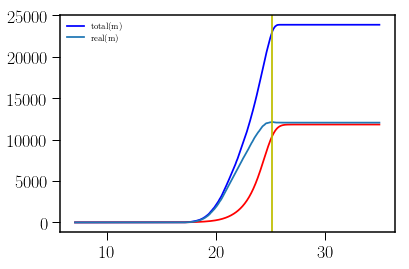

In [39]:
# Compute q(m)
# lofar_rect_cuts = lofar_rect & (deepfull["S_Code"] == "S") & (deepfull["Maj"]*3600. <= maj_cut)
# lofar_co_test = SkyCoord(deepfull['RA'][lofar_rect_cuts], deepfull['DEC'][lofar_rect_cuts], unit=(u.deg,u.deg),
#                    frame='icrs')
RMAX = 5.

qm_i_old, tm_i, rm_i = get_q_m(lofar_co, i_coords, RMAX,
               master[mag_col][i_only_bool], nm_be_i, pan_area, nm_i_old)

nm_i = get_n_m_kde(master[mag_col][master_rect_ind], nm_bc_i, area=pan_area, bandwidth=0.5)
qm_i = estimate_q_m_kde(master[mag_col][i_only_bool], nm_bc_i, nm_i,
                        lofar_co, i_coords, RMAX, bandwidth=0.5)

fig = plt.figure()

plt.plot(nm_bc_i, np.cumsum(qm_i), label='KDE')
plt.plot(nm_bc_i, qm_i_old, label='Cumulative')
plt.legend()

fig = plt.figure()

plt.plot(nm_bc_i, tm_i, color='b', label='total(m)')
plt.plot(nm_bc_i, np.pi * RMAX**2 * np.cumsum(nm_i) * (len(lofar_co)), color='r')
plt.plot(nm_bc_i, rm_i, label='real(m)')
plt.axvline(x=nm_bc_i[np.argmax(rm_i)], ymin=0, ymax=1, color='y')

#plt.yscale('log')
plt.legend()


In [40]:
# Write the q(m) distribution to pckl file to compare with the other fields
pickle.dump([nm_bc_i, qm_i, qm_i_old], open("Bootes_qm_i_2asec.pckl", "wb"))

### Compute Q$_0$ <a class="anchor" id="comp-q0_i"></a>

#### Firstly, redefine coordinates to include all the sources in the overlapping area

Timetaken: 3.856074571609497
Radius Blanks Random Blanks Q_0
1 7128 17704 0.5973791233619521
2 3984 16065 0.7520074696545285
3 3211 13819 0.7676387582314205
4 2737 11395 0.7598069328652918
5 2294 9003 0.7451960457625236
6 1974 7013 0.718522743476401
7 1698 5499 0.691216584833606
8 1436 4358 0.6704910509407985
9 1231 3598 0.6578654808226793


Text(0, 0.5, '$Q_0$')

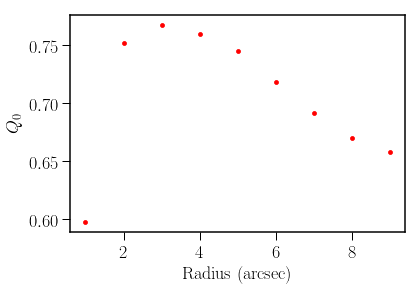

In [13]:
# Compute Q_0 for the i band

t1 = time.time()

# Empty lists to store the output from the PanSTARRS catalogue
q0_li = []
l_no_m_i = []
r_no_m_i = []

rad = np.arange(1,10)

# Generate random coords
rand_coords = generate_rand_pos_bootes(p_ra_up,p_dec_up,p_ra_down,p_dec_down,len(lofar_rect))

for k in range(len(rad)):
    q0_i, nl_non_i, nr_non_i = get_Q0(lofar_rect, i_coords, rand_coords, float(rad[k]))
    q0_li.append(q0_i)
    l_no_m_i.append(nl_non_i)
    r_no_m_i.append(nr_non_i)

print('Timetaken: ' + str(time.time() - t1))

print('Radius Blanks Random Blanks Q_0')

for aa in range(len(q0_li)):
    
    print(rad[aa], l_no_m_i[aa], r_no_m_i[aa], q0_li[aa])


# Make a plot of Q0 vs radius
fig_q0 = plt.figure()

plt.plot(rad, q0_li, 'r.')
#plt.yscale('log')
plt.xlabel('Radius (arcsec)')
plt.ylabel('$Q_0$')

In [14]:
# Estimate a mean Q_0 value for the i-band
mean_Q0_vals = []
mean_Q0_i = np.mean(q0_li[1:5])
# mean_Q0_i = np.max(q0_li)
print(mean_Q0_i)

mean_Q0_vals.append(mean_Q0_i)
# print("TAKING THE MAX of the Q0 vs radius distribution!")
print("Q_0 for i band: " + str(mean_Q0_i))

0.7561623016284411
Q_0 for i band: 0.7561623016284411


### Compute LR i-band <a class="anchor" id="run-lr_i"></a>

In [15]:
# Add the positional uncertainties column
opt_pos_err = 0.35 # / 3600.       # In degrees
# master["ERR_RA"] = opt_pos_err
# master["ERR_DEC"] = opt_pos_err

# Make the subset of MASTER catalogue which are in "i"
master_categ = master[i_only_bool]
print("Sources with i-band detection: " + str(len(master_categ)))

Sources with i-band detection: 1468723


In [16]:
# First match LOFAR to the MASTER catalogue -
# then calculate sigma for all matches in the optical catalogue 
# to a given LOFAR source

# Convert master positions to SkyCoord object
master_coords = SkyCoord(master_categ['ALPHA_J2000'], master_categ['DELTA_J2000'],
                         unit=(u.deg, u.deg), frame='icrs')

# New search radius to match the LOFAR and combined PanSTARRS WISE caalogue
lof_opt_rad = 15.

# Match the coordinates
indx_l, indx_m, s2d, _ = search_around_sky(lofar_co, master_coords, 
                                           lof_opt_rad*u.arcsec)

# This match returns x of possible counterparts within 15'' of a
# LOFAR source - compute LR for all x sources wrt the LOFAR source
# Take the max value of the LR


# Get the indices of LOFAR which have at least one match - only need to calculate LR for these sources
ind_l_un = np.unique(indx_l)
print(len(ind_l_un))
print("No. of radio sources without any positional cross-match: {0}".format(len(lofar_co) - len(ind_l_un)))

17644
No. of radio sources without any positional cross-match: 619


In [17]:
# Functino to compute ML based on magnitude of possible conterpart and the sigma

def apply_ml(i, opt_cat_era, opt_cat_edec, opt_cat_mag, fn_opt_indices, mean_Q0, nm_categ, qm_categ, nm_bc_categ):
    """
    Function which combines previous routines to compute ML values 
    for each ith LOFAR source that has a match within 15'' to opt/NIR catalogue
    
    Parameters:
    -----------
    i : Index of the LOFAR coordinates
    opt_cat_era : All of optical RA errors
    opt_cat_edec : All of optical Dec errors
    opt_cat_mag : All of the optical magnitudes
    fn_opt_indices : Field name of indices in MASTER catalogue
    mean_Q0 : Mean Q0 value for the band
    nm_categ : Cumulative n(m) distribution for the category
    qm_categ : Cumulative q(m) distribution for the category
    nm_bc_categ : Bin centres from the n(m) distribution
    
    Returns:
    --------
    res = [opt_index,dist,lr_value] : [Index into the optical catalogue,
                                        Separation to counterpart,
                                        LR value]
    """
    
    # Get the indices into the corresponding MASTER_category catalogue
    indx_o_match = indx_m[indx_l == i]
    s2d_o = s2d[indx_l == i]  # The 2d separation of the sources from LOFAR source
    
    # Indices corresponding to the FULL MASTER catalogue - the -1 to get into python index notation
    indx_o_master = master_categ["ID"][indx_o_match]
    
    # Get the indices into the ACTUAL optical catalogue
    # indx_o = master_categ[fn_opt_indices][indx_o_match] -- Not used anymore with new catalogue
    
    # Now only select the optical catalogue sources which have an index value in master catalogue
    # indx_o_match = indx_o_match[indx_o != -99.]
    # s2d_o = s2d_o[indx_o != -99.]
    # indx_o = indx_o[indx_o != -99.]
    
    # Get the LOFAR positions and errors
    lofar_ra = final['RA'][i]
    lofar_dec = final['DEC'][i]
    lofar_pa = final['PA'][i]
    lofar_maj_err = final['E_Maj'][i]
    lofar_min_err = final['E_Min'][i]
    
    # Get the optical/NIR counterpart positions and positional errors
    c_ra = master_categ['ALPHA_J2000'][indx_o_match]
    c_dec = master_categ['DELTA_J2000'][indx_o_match]
    c_ra_err = opt_cat_era[indx_o_match]
    c_dec_err = opt_cat_edec[indx_o_match]
    
    # Magnitude of the counterparts
    c_mag = opt_cat_mag[indx_o_match]
    
    # Compute the sigma value for the ith LOFAR source and the possible
    # len(indx_o) optical counterparts
    
    """sig, sig_maj, sig_min = get_sigma_all_old(lofar_maj_err, lofar_min_err,
                                         lofar_pa, lofar_ra, lofar_dec,
                                         c_ra, c_dec, c_ra_err, c_dec_err)"""
    
    # New corrected angles Gaussian code - sig^2 is actually sigma_0_0 i.e. the average pos err squared?
    sigma_0_0, det_sigma = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)
    
    
    
    # Compute the LR of all the possible counterparts
    # Set the last argument to False if you do not want to apply the F(r) factor to q(m)
    c_lr = get_lr(c_mag, mean_Q0, nm_categ, qm_categ, np.sqrt(sigma_0_0), 
                  sigma_0_0, det_sigma, s2d_o.arcsec, nm_bc_categ, lof_opt_rad, True) 
    
    # Get indices of n=4 maximum values
    # lr_max_ind = c_lr.argsort()[-3:][::-1]
    
    # Get the index of the maximum 
    lr_max_ind = np.argmax(c_lr)
    
    
    result = [indx_o_master[lr_max_ind],     # i_band_index into the FULL master catalogue
              (s2d_o.arcsec)[lr_max_ind],    # Separation between counterpart and LOFAR source
              c_lr[lr_max_ind]]              # Max LR value
    
    return result



In [18]:

# A wrapper function to use multiple arguments
def merge_names_unpack(args):
    return apply_ml(*args)

# The number of cpu's to use
ncpu = mp.cpu_count()
ncpu_use = np.max([1, ncpu-1])

def run_parallel(i, opt_cat_era, opt_cat_edec, opt_cat_mag, fn_opt_indices, mean_Q0, nm_categ, qm_categ, nm_bc_categ):
    
    pool = mp.Pool(processes=ncpu_use)
    #resu = pool.map(partial(apply_ml, opt_cat_era, opt_cat_edec, opt_cat_mag, 
    #                          fn_opt_indices, mean_Q0, nm_categ, qm_categ, nm_bc_categ), i)

    resu = pool.map(partial(apply_ml, opt_cat_era=opt_cat_era, opt_cat_edec=opt_cat_edec,
                                        opt_cat_mag=opt_cat_mag,fn_opt_indices=fn_opt_indices,
                                        mean_Q0=mean_Q0, nm_categ=nm_categ, qm_categ=qm_categ, nm_bc_categ=nm_bc_categ),i)

    return resu

t4 = time.time()
# ind_l_un = ind_l_un[:10]

res = run_parallel(ind_l_un, opt_pos_err*np.ones(len(master)), opt_pos_err*np.ones(len(master)),
                   master_categ[mag_col],'does_not_matter',
                   mean_Q0_i, nm_i, qm_i, nm_bc_i)

print(time.time() - t4)

lr_type = "i"

# Create columns in the LOFAR catalogue to store the output of ML in iband
final["lr_"+lr_type] = np.nan
final["lr_dist_"+lr_type] = np.nan
final["lr_index_"+lr_type] = np.nan

# Map the outputs to a list - all non-matches have a nan value
(final["lr_index_"+lr_type][ind_l_un],
 final["lr_dist_"+lr_type][ind_l_un],
 final["lr_"+lr_type][ind_l_un]) = list(map(list, zip(*res)))

varstat(final["lr_"+lr_type])


10.950337171554565
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
56.630561  19.521963  85.168412  18263      9.474184055679629e-98 496.145104 0         


### i-band LR Threshold


In [19]:
# From older run i.e. when we ran LR on S and Maj < 10'' sources, left here for comparison
# varstat(final["lr_"+lr_type][final["lr_"+lr_type] >0.])
"""Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
52.198868  18.978968  77.120356  14728      9.462457709220904e-98 465.160889 0""";

Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
52.198868  18.978968  77.120356  14728      9.462457709220904e-98 465.160889 0         


/disk1/rohitk/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


i-band threshold: 2.7865202053290554
No of nan LRs: 619
No of sources below threshold: 4303


/disk1/rohitk/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


Text(0.5, 0, '$log(LR)$')

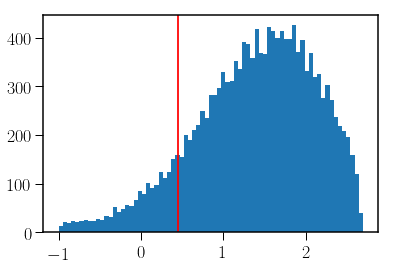

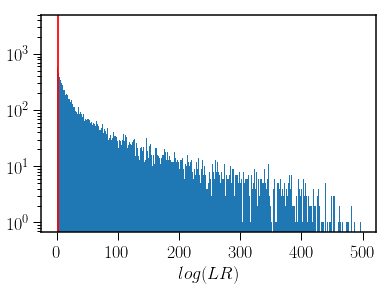

In [19]:
threshold_i = np.nanpercentile(final["lr_"+lr_type], 100*(1 - mean_Q0_i))

print("i-band threshold: "+ str(threshold_i))

print("No of nan LRs: " + str(len(final[np.isnan(final["lr_"+lr_type])])))

print("No of sources below threshold: {0}".format(np.sum(final["lr_"+lr_type] < threshold_i)))

fig = plt.figure()
lr_be = logspace_bins(0.1, np.nanmax(final["lr_"+lr_type]), 0.05)
plt.hist(np.log10(final["lr_"+lr_type][~np.isnan(final["lr_"+lr_type])]), bins=lr_be)
plt.axvline(np.log10(threshold_i), 0, 100000, color='r')

lr_n, lr_e, _ = return_hist_par(1, final["lr_"+lr_type][~np.isnan(final["lr_"+lr_type])])
# print(lr_n)

fig = plt.figure()
plt.hist(final["lr_"+lr_type][~np.isnan(final["lr_"+lr_type])], bins=lr_e)
plt.axvline((threshold_i), 0, 100000, color='r')

# plt.xscale('log')
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('$log(LR)$')

Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
365.945438 360.015011 44.649446  574        300.19591874310805 496.145104 0         
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
22.125329  22.261847  1.813957   17644      16.40304850508916 25.669847  0         


/disk1/rohitk/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/disk1/rohitk/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Text(0, 0.5, '$log(LR)$')

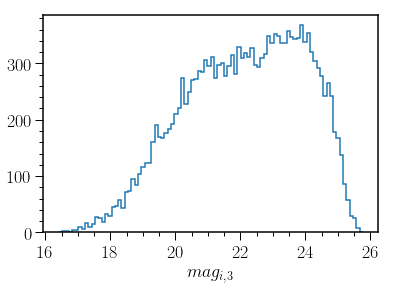

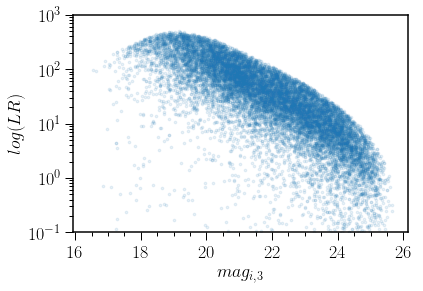

In [20]:
high_lr = final["lr_"+lr_type] > 300
varstat(final["lr_"+lr_type][high_lr])

good_lr_ind = (final["lr_index_"+lr_type][~np.isnan(final["lr_index_"+lr_type])]).astype(int)
varstat(master[mag_col][(final["lr_index_"+lr_type][~np.isnan(final["lr_index_"+lr_type])]).astype(int)])

_, me, mc = return_hist_par(0.1, master[mag_col][good_lr_ind])
fig, ax = make_fig()
plt.hist(master[mag_col][good_lr_ind], bins=me, histtype='step', lw=1.5)
plt.xlabel('$mag_{i,3}$')

fig, ax = make_fig()
plt.scatter(master[mag_col][good_lr_ind], (final["lr_"+lr_type][~np.isnan(final["lr_index_"+lr_type])]),
            s=7, alpha=0.1)
plt.yscale('log')
plt.ylim([0.1, 1000])
plt.xlabel('$mag_{i,3}$')
plt.ylabel('$log(LR)$')

## Spitzer Ch2 filter <a class="anchor" id="k-analysis"></a>

In [22]:
# Define the mag column and the filter
filt = "ch2"
mag_col = filt + "_mag_3"
flux_col = filt + "_flux_3"
fluxerr_col = filt + "_fluxerr_3"

# Get the sources with SNR > threshold in the filter
snr_band = (master[flux_col] / master[fluxerr_col] >= snr_th)

In [23]:
# Find all the optical catalogue sources within the rectangle and those with non-99 magnitudes
master_rect_ind = ((field_filter(p_ra_up, p_dec_up, p_ra_down, p_dec_down, master["ALPHA_J2000"], master["DELTA_J2000"])) &
                   (master[mag_col] != null_mag) & (~np.isnan(master[mag_col])) & flag_cond & snr_band)

# Flag_cond select all sources which have a DEEP_FLAG = 1 or -99 (i.e. Spitzer-only sources)

print("No. of ch2 sources in rectangular area: " + str(np.sum(master_rect_ind)))

No. of ch2 sources in rectangular area: 175708


### n(m) Spitzer 4.5$\mu$m <a class="anchor" id="comp-nm_k"></a>

Properties of n(m) in K-band: 
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
0.002622   0.001554   0.002606   559        9.098559160603292e-32 0.005484   0         


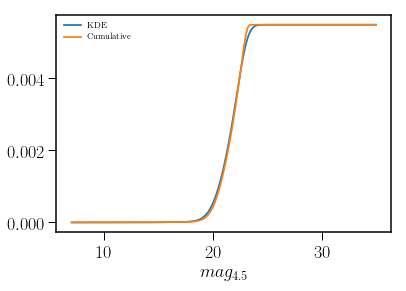

In [24]:
# Get the bin_list for computing n(m) for g band
# _, nm_be_k, nm_bc_k = return_hist_par(0.05, master[mag_col][master_rect_ind])

nm_be_k, nm_bc_k = gen_binc_binl(7., 35., 0.05)

# Get n(m) for the g band
nm_k_old = get_n_m(master[mag_col][master_rect_ind], nm_be_k, pan_area)

nm_k = get_n_m_kde(master[mag_col][master_rect_ind], nm_bc_k, area=pan_area, bandwidth=0.5)

# Print properties of the n(m) distribution
print("Properties of n(m) in K-band: ")
varstat(np.cumsum(nm_k))

fig = plt.figure()

plt.plot(nm_bc_k, np.cumsum(nm_k), label='KDE')
plt.plot(nm_bc_k, nm_k_old, label='Cumulative')
plt.xlabel('$mag_{4.5}$')
plt.legend()


In [26]:
# Write the n(m) distribution to pckl file to compare with the other fields
pickle.dump([nm_bc_k, nm_k, nm_k_old], open("Bootes_nm_ir_3asec.pckl", "wb"))

### q(m) Spitzer 4.5 $\mu$m <a class="anchor" id="comp-qm_k"></a>

In [28]:
# Redefine the coordinates list to include all the overlapping sources (NOT only in rectangle)
# Define i-only sources as sources with a SNR > 3 (or 5) in the i-band
snr_th = 3.

ir_only_bool = ((master[flux_col] / master[fluxerr_col] >= snr_th) &
               (master[mag_col] != -99) & (~np.isnan(master[mag_col])) & (master["FLAG_DEEP"] == 1))

ir_only_bool = ((master[flux_col] / master[fluxerr_col] >= snr_th) & master["FLAG_DEEP"] == 1)

ir_only_bool = (flag_cond) & (master[mag_col] != null_mag) & (~np.isnan(master[mag_col])) & snr_band

# i_only_bool = (master[mag_col] != 99) & (~np.isnan(master[mag_col]))
# print(np.sum(i_only_bool))

ir_coords = SkyCoord(master['ALPHA_J2000'][ir_only_bool], 
                       master['DELTA_J2000'][ir_only_bool],
                       unit=(u.deg,u.deg),frame='icrs')

print("No. of LOFAR and I-band sources used in analysis from now on: ", len(lofar_co))
print("No. of i-band sources used for LR cross-match: {0}".format(np.sum(ir_only_bool)))

No. of LOFAR and I-band sources used in analysis from now on:  15291
No. of i-band sources used for LR cross-match: 803759


Unique opt_ind:  23093
Unique LOFAR ind:  14038
q(m) statistics: 
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
0.001789   0.0        0.004292   559        0.0 0.018268   226       
6660610
real m
4903801.039030591


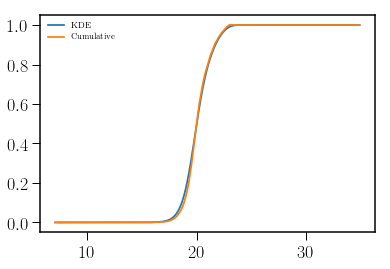

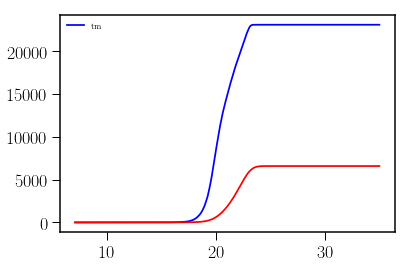

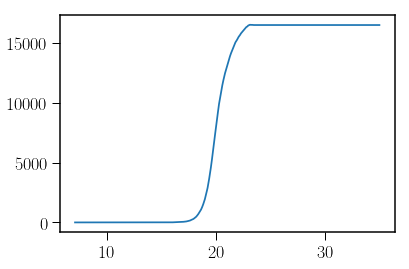

In [31]:
RMAX = 5.


qm_k_old, tm_k, rm_k = get_q_m(lofar_co, ir_coords, RMAX,
               master[mag_col][(ir_only_bool)], nm_be_k, pan_area, nm_k_old)

qm_k = estimate_q_m_kde(master[mag_col][ir_only_bool], nm_bc_k, nm_k,
                        lofar_co, ir_coords, RMAX, bandwidth=0.5)

fig = plt.figure()
plt.plot(nm_bc_k, np.cumsum(qm_k), label='KDE')
plt.plot(nm_bc_k, qm_k_old, label='Cumulative')
plt.legend()

fig = plt.figure()
plt.plot(nm_bc_k, tm_k, color='b', label='tm')
plt.plot(nm_bc_k, np.pi*RMAX**2*np.cumsum(nm_k)*len(lofar_co), color='r')
plt.legend()

fig = plt.figure()

plt.plot(nm_bc_k, rm_k)

print("q(m) statistics: ")
varstat(qm_k)

print(np.sum(tm_k))
print("real m")
print(np.sum(rm_k))

In [32]:
# Write the q(m) distribution to pckl file to compare with the other fields
pickle.dump([nm_bc_k, qm_k, qm_k_old], open("Bootes_qm_ir_3asec.pckl", "wb"))

## Compute Q$_0$ <a class="anchor" id="comp-Q0_k"></a>

Timetaken: 3.0153725147247314
Radius Blanks Random Blanks Q_0
1 5610 17948 0.6874303543570315
2 2167 17049 0.8728957710129627
3 1630 15646 0.8958200178959479
4 1452 13978 0.8961224781799971
5 1338 12123 0.8896312793862905
6 1244 10371 0.8800501398129399
7 1127 8645 0.8696356275303644
8 1003 7078 0.8582933031929924
9 889 5754 0.8454987834549879


Text(0, 0.5, '$Q_0$')

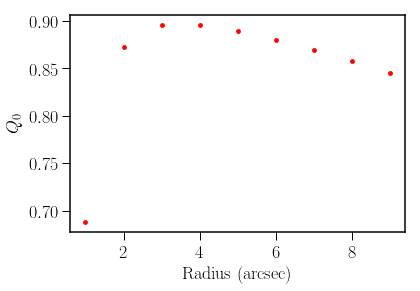

In [26]:
# Compute Q_0 for the g band

t1 = time.time()

# Empty lists to store the output from the PanSTARRS catalogue
q0_lk = []
l_no_m_k = []
r_no_m_k = []

rad = np.arange(1,10)

# DON'T GENERATE THE RANDOM COORDINATES AGAIN

# Generate random coords
rand_coords = generate_rand_pos_bootes(p_ra_up,p_dec_up,p_ra_down,p_dec_down,len(lofar_rect))

for k in range(len(rad)):
    q0_k, nl_non_k, nr_non_k = get_Q0(lofar_rect, ir_coords, rand_coords, float(rad[k]))
    q0_lk.append(q0_k)
    l_no_m_k.append(nl_non_k)
    r_no_m_k.append(nr_non_k)

print('Timetaken: ' + str(time.time() - t1))

print('Radius Blanks Random Blanks Q_0')

for aa in range(len(q0_lk)):
    
    print(rad[aa], l_no_m_k[aa], r_no_m_k[aa], q0_lk[aa])


# Make a plot of Q0 vs radius
fig_q0 = plt.figure()

plt.plot(rad, q0_lk, 'r.')
#plt.yscale('log')
plt.xlabel('Radius (arcsec)')
plt.ylabel('$Q_0$')

In [27]:
# Estimate a mean Q_0 value for the i-band

mean_Q0_k = np.mean(q0_lk[1:5])
# mean_Q0_k = np.max(q0_lk)

print("Q_0 for K-band: " + str(mean_Q0_k))
mean_Q0_vals.append(mean_Q0_k)

Q_0 for K-band: 0.8886173866187995


## Compute LR for K-band <a class="anchor" id="comp-lr_k"></a>

In [28]:
# Define the sub catalogue of master sources that are "K_only"
master_categ = master[ir_only_bool]
print("Sources with Spitzer ch2 detection: " + str(len(master_categ)))

Sources with Spitzer ch2 detection: 803759


In [29]:
# First match LOFAR to the MASTER catalogue -
# then calculate sigma for all matches in the optical catalogue 
# to a given LOFAR source

# Convert master positions to SkyCoord object
master_coords = SkyCoord(master_categ['ALPHA_J2000'], master_categ['DELTA_J2000'],
                         unit=(u.deg, u.deg), frame='icrs')

# New search radius to match the LOFAR and combined PanSTARRS WISE caalogue
lof_opt_rad = 15.

# Match the coordinates
indx_l, indx_m, s2d, _ = search_around_sky(lofar_co, master_coords, 
                                           lof_opt_rad*u.arcsec)

# Get the indices of LOFAR which have at least one match - only need to calculate LR for these sources
ind_l_un = np.unique(indx_l)
print(len(ind_l_un))
print("No. of radio sources without any positional cross-match: {0}".format(len(lofar_co) - len(ind_l_un)))

17895
No. of radio sources without any positional cross-match: 368


In [30]:
# Run the ML function

# Pixel scale for the K-band - to convert from xErr to raErr, etc
K_pix_scale = 0.2

t3 = time.time()


# Run the apply_ml function and store the values in res as a list
"""res = []
for aa in ind_l_un:
    res.append(apply_ml(aa,K_pix_scale*ukidss_cat['xErr'],K_pix_scale*ukidss_cat['yErr'],
                        ukidss_cat['kHallMag'],'K_band_index',mean_Q0_k, nm_k, qm_k, nm_bc_k))

print(time.time() - t3)
""";

t4 = time.time()

res = run_parallel(ind_l_un, opt_pos_err*np.ones(len(master)), opt_pos_err*np.ones(len(master)),
                        master_categ[mag_col], 'does_not_matter',mean_Q0_k, nm_k, qm_k, nm_bc_k)

print(time.time() - t4)

lr_type = "ch2"
# Create columns in the LOFAR catalogue to store the output of ML in iband
final["lr_"+lr_type] = np.nan
final["lr_dist_"+lr_type] = np.nan
final["lr_index_"+lr_type] = np.nan

# Map the outputs to a list - all non-matches have a nan value
(final["lr_index_"+lr_type][ind_l_un],
 final["lr_dist_"+lr_type][ind_l_un],
 final["lr_"+lr_type][ind_l_un]) = list(map(list, zip(*res)))

# Convert the index into ints as the map converts them to float
# final["lr_index_K"] = final["lr_index_K"].astype(int)

varstat(final["lr_"+lr_type])

8.699378967285156
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
157.343373 83.617974  195.407741 18263      0.0 1224.293776 4         


ch2-band threshold: 5.741713577977949
No of nan LRs: 368
No of sources below threshold: 1994


/disk1/rohitk/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/disk1/rohitk/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0, '$log(LR)$')

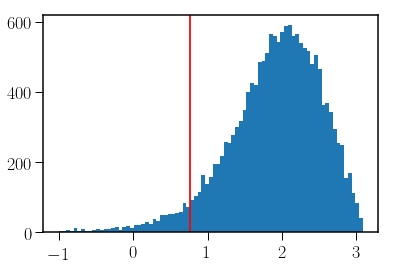

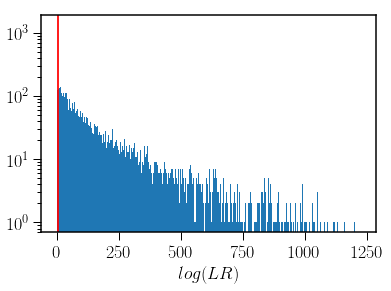

In [31]:
threshold_ch2 = np.nanpercentile(final["lr_"+lr_type], 100*(1 - mean_Q0_k))

print("ch2-band threshold: "+ str(threshold_ch2))

print("No of nan LRs: " + str(len(final[np.isnan(final["lr_"+lr_type])])))

print("No of sources below threshold: {0}".format(np.sum(final["lr_"+lr_type] < threshold_ch2)))

fig = plt.figure()
lr_be = logspace_bins(0.1, np.nanmax(final["lr_"+lr_type]), 0.05)
plt.hist(np.log10(final["lr_"+lr_type][~np.isnan(final["lr_"+lr_type])]), bins=lr_be)
plt.axvline(np.log10(threshold_ch2), 0, 100000, color='r')

lr_n, lr_e, _ = return_hist_par(1, final["lr_"+lr_type][~np.isnan(final["lr_"+lr_type])])
# print(lr_n)

fig = plt.figure()
plt.hist(final["lr_"+lr_type][~np.isnan(final["lr_"+lr_type])], bins=lr_e)
plt.axvline((threshold_ch2), 0, 100000, color='r')

# plt.xscale('log')
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('$log(LR)$')

Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
523.030582 462.640207 198.770703 2955       300.0244203357923 1224.293776 0         
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
19.988079  19.913254  1.083214   17895      12.143552608004494 23.292252  0         


/disk1/rohitk/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/disk1/rohitk/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Text(0, 0.5, '$log(LR)$')

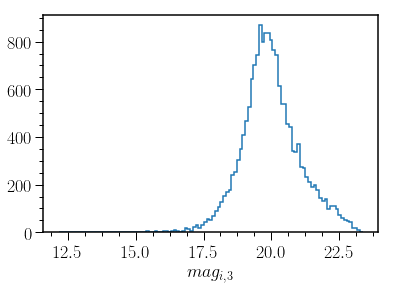

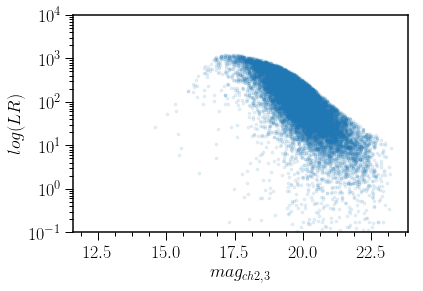

In [32]:
high_lr = final["lr_"+lr_type] > 300
varstat(final["lr_"+lr_type][high_lr])

good_lr_ind = (final["lr_index_"+lr_type][~np.isnan(final["lr_index_"+lr_type])]).astype(int)
varstat(master[mag_col][(final["lr_index_"+lr_type][~np.isnan(final["lr_index_"+lr_type])]).astype(int)])

_, me, mc = return_hist_par(0.1, master[mag_col][good_lr_ind])
fig, ax = make_fig()
plt.hist(master[mag_col][good_lr_ind], bins=me, histtype='step', lw=1.5)
plt.xlabel('$mag_{i,3}$')

fig, ax = make_fig()
plt.scatter(master[mag_col][good_lr_ind], (final["lr_"+lr_type][~np.isnan(final["lr_index_"+lr_type])]),
            s=7, alpha=0.1)
plt.yscale('log')
plt.ylim([0.1, 10000])
plt.xlabel('$mag_{ch2,3}$')
plt.ylabel('$log(LR)$')

# Run until here for now #

In [33]:
# Make a directory based on when the code is run to store output

if workflow_iter:
    add_str = "_workflow"
else:
    add_str = ""

# Make the general directory to store the catalogue
if os.path.exists(strftime("run1_matches"+add_str+"/%d_%m_%Y_1")):
    # Get list of directories created today
    outdir_name = strftime("run1_matches"+add_str+"/%d_%m_%Y")
    dirs_today = sorted(glob.glob(outdir_name+"*"))

    # Now create a new output directory name by adding one to the last number
    last_num = int(dirs_today[-1][-1])
    
    # Now finally create the directory
    outdir_name = outdir_name+"_"+str(last_num+1)
    print(outdir_name)
    os.makedirs(outdir_name)
else:
    outdir_name = strftime("run1_matches"+add_str+"/%d_%m_%Y_1")
    os.makedirs(outdir_name)


In [34]:
outdir_name

'run1_matches_workflow/05_04_2019_1'

In [35]:
# Edit sources such that soucres below threshold are nans

# run_type = "1_faint"
run_type = "1"

field = "Bootes"

# Write the matches before setting threshold to be nan's
final.write(outdir_name + '/' + field + '_ML_RUN'+run_type + cat_type, format='ascii', overwrite=True)
final.write(outdir_name + '/' + field + '_ML_RUN'+run_type+cat_type+'.fits', format='fits', overwrite=True)

final["lr_index_i"][final["lr_i"] < threshold_i] = np.nan
final["lr_index_ch2"][final["lr_ch2"] < threshold_ch2] = np.nan

final["lr_dist_i"][final["lr_i"] < threshold_i] = np.nan
final["lr_dist_ch2"][final["lr_ch2"] < threshold_ch2] = np.nan

final["lr_i"][final["lr_i"] < threshold_i] = np.nan
final["lr_ch2"][final["lr_ch2"] < threshold_ch2] = np.nan

final.write(outdir_name + '/' + field + '_ML_RUN'+run_type+cat_type+'_nanth', format='ascii', overwrite=True)
final.write(outdir_name + '/' + field + '_ML_RUN'+run_type+cat_type+'_nanth.fits', format='fits', overwrite=True)

print(time.time() - ts)
print("Mean Q0s: ")
print(mean_Q0_vals)

run1_filts = ["i", "ch2"]

# Write the mean Q0s to pckl file too
pickle.dump([run1_filts, mean_Q0_vals], open(outdir_name + "/run1_filts_and_mean_Q0.pckl", "wb"))

/disk1/rohitk/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


369.06297540664673
Mean Q0s: 
[0.7561623016284411, 0.8886173866187995]


In [36]:
good_lr_i = final["lr_i"] >= threshold_i
good_lr_ir = final["lr_ch2"] >= threshold_ch2
print("LR > threshold i: {0}".format(np.sum(good_lr_i)))
print("LR > threshold IR: {0}".format(np.sum(good_lr_ir)))

print("LR > threshold in both optical and IR: {0}, {1}".format(np.sum(good_lr_i & good_lr_ir), np.sum(good_lr_i & good_lr_ir)/len(final)))
print("LR > threshold in optical OR IR: {0}, {1}".format(np.sum(good_lr_i | good_lr_ir), np.sum(good_lr_i | good_lr_ir)/len(final)))


LR > threshold i: 13341
LR > threshold IR: 15901
LR > threshold in both optical and IR: 13224, 0.7240869517603898
LR > threshold in optical OR IR: 16018, 0.8770738651919181


/disk1/rohitk/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)


In [37]:
# Find the number of sources above the threshold in any of the bands
n_th = (~np.isnan(final["lr_i"]) | ~np.isnan(final["lr_ch2"]))
print("No. of sources above threshold in any band: " + str(len(final[n_th])))

print("Frac. of LOFAR sources above threshold : " + str(len(final[n_th])/float(len(final))))


# To be finished--------------------------
# Now assign a lr_1, lr_index_1 and lr_dist_1 to each LOFAR sources based on the maximum LR value in any of the bands

"""
# First category - Match in all of the sources
final["lr_1"] = np.nan
final["lr_1"][n_th] = np.max((final["lr_i"][n_th], final["lr_g"][n_th], 
                           final["lr_K"][n_th], final["lr_s"][n_th]), axis=0)
final["lr_type_1"] = 0
final["lr_type_1"][n_th] = np.argmax((final["lr_i"][n_th], final["lr_g"][n_th], 
                           final["lr_K"][n_th], final["lr_s"][n_th]), axis=0) + 1
""";
#--------------------------------------------

No. of sources above threshold in any band: 16018
Frac. of LOFAR sources above threshold : 0.8770738651919181


In [38]:
# Move the HTML notebook to the output directory
os.system("jupyter-nbconvert MaxL_RUN1_bootes.ipynb && mv MaxL_RUN1_bootes.html {0}".format(outdir_name))

0

### i-K and g-i colour categories <a class="anchor" id="gik_col_cat"></a>

In [ ]:
# master indices
master_indices_arr = np.arange(len(master))

In [ ]:
# i-K colour
master["iK_col"] = np.nan
master["iK_col"] = master["i_psfMag"] - master["kHallMag"]

# g-i colours
master["gi_col"] = np.nan
master["gi_col"] = master["g_psfMag"] - master["i_psfMag"]

# Separate the objects into the i-K colour indices

# Colour bin width
col_bin_width = 0.2

# Number of i-K colour bins
n_ik_bins = len(np.arange(3.5,4.9, col_bin_width)) + 1

# Generate the un-even width colour bins
iK_col_bins = np.zeros(n_ik_bins)
iK_col_bins[0] = 3.0
iK_col_bins[1:] = np.arange(3.5,4.9,col_bin_width)
iK_col_bins[6] = 4.6
iK_col_bins[7] = 5.
iK_col_bins[8] = 6.

print("i-K bins: ")
print(iK_col_bins)

def get_giK_bin_indices(iK_bin_list):
    """
    Get the indices of objects in each giK colour bins 
    10 i-K colour bins --> further divided into 2 equal g-i colour halves
    
    Parameters:
    -----------
    
    iK_bin_list : Bin list of i-K colours
    
    Returns:
    --------
    [iK_ind, : Indices in each i-K bin
    gi_upper, : Indices in upper g-i bin for each jth i-K bin
    gi_lower] : Indices in lower g-i bin for each jth i-K bin
    """
    
    iK_digitize = np.digitize(master["iK_col"], bins=iK_bin_list)

    # Prints the number of objects within the entire colour range
    #print(len(master[(iK_col_bins[0] <= master["iK_col"]) & (master["iK_col"] <= iK_col_bins[-1])]))

    # All the colours but as separate bins
    iK_all_ind = []

    # Gives indices of objects in each bin
    for k in range(1,len(np.unique(iK_digitize))-1):
        iK_all_ind.append(iK_digitize == k)
    
    # Now split each iK bin into equal halves in gi colour
    gi_lower = []
    gi_upper = []

    for aa in range(len(iK_all_ind)):
        
        # Subset of master indices within the jth i-K bin
        master_ind_subset_bin = master_indices_arr[iK_all_ind[aa]]
    
        # Find the median g-i colour
        gi_median = np.nanmedian(master["gi_col"][iK_all_ind[aa]])
        
        # Get indices of objects within the upper and lower half of the g-i bin
        # that index into the FULL master catalogue
        gi_low_master_ind = master_ind_subset_bin[master["gi_col"][iK_all_ind[aa]] <= gi_median]
        gi_upp_master_ind = master_ind_subset_bin[master["gi_col"][iK_all_ind[aa]] > gi_median]
        
        # Split into higher or lower than the median - this should not select any nan values (the less/greater than)
        gi_lower.append(np.isin(master_indices_arr, gi_low_master_ind, assume_unique=True))
        gi_upper.append(np.isin(master_indices_arr, gi_upp_master_ind, assume_unique=True))
        
    return [iK_all_ind, gi_upper, gi_lower] # Don't actually need to return iK_all_ind